In [3]:
%matplotlib inline
import numpy as np
import scipy
import PIL
import matplotlib.pyplot as plt
import PIL.Image as im
from scipy import ndimage
from PIL import ImageEnhance
import random

show = lambda img: plt.imshow(img)
gshow = lambda img: plt.imshow(img, cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

im = scipy.misc.imread('../test_large2.JPG',flatten=True)

def HE_serial(im_in):
    im = im_in.copy()
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    cum_hist = np.cumsum(histogram)
    equal_hist = (cum_hist*256).astype(int)
    mapfunc = dict(zip(range(256), equal_hist))
    new_im = np.zeros_like(im)
    for i in range(height):
        for j in range(width):
            new_im[i,j] = mapfunc[im[i,j]]
    
    return new_im
    #plt.plot(range(0,256), cum_hist)

def histogram(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), histogram)
    #return histogram
    
def cumhist(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), np.cumsum(histogram))

In [4]:
im_small = np.array([im[i][::12] for i in range(len(im)) if i%12==0])

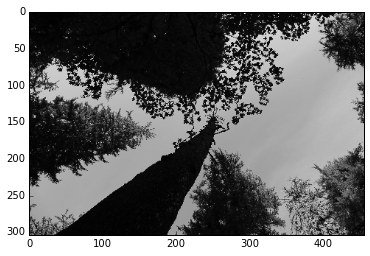

In [5]:
gshow(im_small)

In [100]:
%%time
new1 = HE_serial(im_small.astype(int))

CPU times: user 111 ms, sys: 3.8 ms, total: 115 ms
Wall time: 115 ms


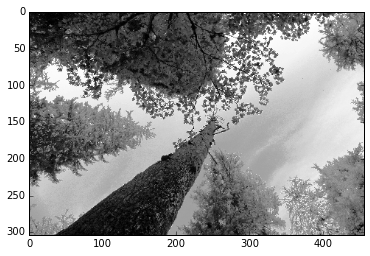

In [101]:
gshow(new1)

In [130]:
# Gain definition: with A = 10, S0=100, K=-10/100=0.1


def LHE_serial(im_input):
    gain = lambda s,A,S0: A-A/S0*s if A-A/S0*s>1 else 1
    im = im_input.copy()
    height, width = im.shape
    im = np.pad(im, 4, mode='edge')
    new = np.zeros([height,width])
    for h in range(4,height+4):
        for w in range(4, width+4):
            window = im[h-4:h+5,w-4:w+5]
            old = im[h,w]
            M = np.mean(window)
            S = np.std(window)
            G = gain(S,20,10)
#             B = 0
#             if S*G-M>0:
#                 B = G*S-M
#             if S*G+M>255:
#                 B =(M+G*S)-255
            B=(128-M)*0.25
            N = (old-M)*G+B+M
            #if w==20:
                #print old,M,S,G,B,N
            if N>255:
                new[h-4,w-4]=255
            elif N<0:
                new[h-4,w-4]=0
            else:
                new[h-4,w-4]=N
    return new.astype(int)

In [135]:
a=[[1,2],[3,4],[5,6]]

In [136]:
a[::-1]

[[5, 6], [3, 4], [1, 2]]

In [131]:
temp1 = LHE_serial(im_small)

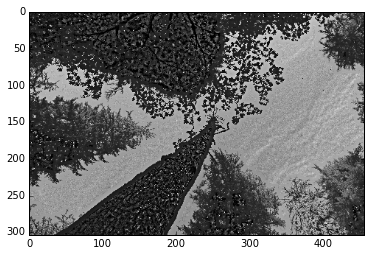

In [132]:
gshow(temp1)

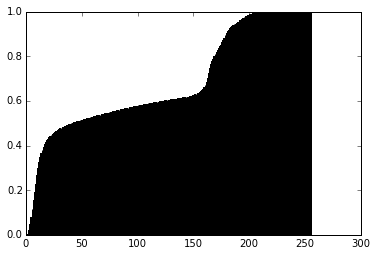

In [133]:
cumhist(im_small.astype(int))

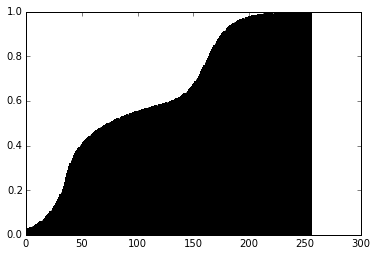

In [134]:
cumhist(temp1.astype(int))

###

In [137]:
def histeq(im):

    #get image histogram
    hist,bins = np.histogram(im,256,normed=True)
    cdf = hist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize

    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape), cdf


In [11]:
?np.histogram

In [145]:
%%time
new3 = HE_serial(im.astype(int))

CPU times: user 11.8 s, sys: 254 ms, total: 12.1 s
Wall time: 12.1 s


In [146]:
%%time
new2,cdf = histeq(im)

CPU times: user 654 ms, sys: 151 ms, total: 805 ms
Wall time: 808 ms


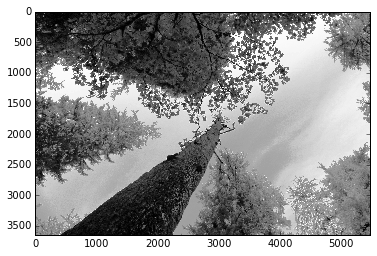

In [144]:
gshow(new3)

### serial LHE

In [12]:
def AHE_serial(im_input, windowwidth=21):
    im = im_input.copy()
    height, width = im.shape
    new = np.zeros([height,width])
    d = windowwidth/2
    
    for h in range(height):
        for w in range(width):
            cur = im[h,w]
            window = im[h-d if h-d>-1 else 0:h+d+1 if h+d+1<height else height,
                        w-d if w-d>-1 else 0:w+d+1 if w+d+1<width else width]
            flat = [i for sub in window for i in sub]
            flat = flat + random.sample(flat+flat+flat+flat, windowwidth*windowwidth-len(flat))
            idx = np.sort(np.array(flat)).tolist().index(cur)
            
            new[h,w] = int(idx*1.0/windowwidth/windowwidth*256)
        print h
    
    gshow(new)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

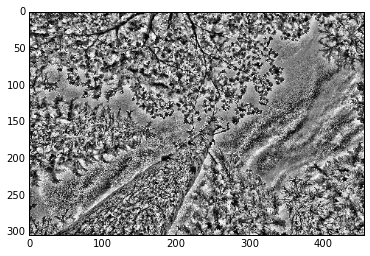

In [14]:
%%time
im_small = AHE_serial(im_small)

In [10]:
histogram(im_small)

TypeError: list indices must be integers, not numpy.float32